## Random Forest ⏰

### Random Forest Sin y Con Bayesian Search ⏰

In [22]:
!pip install scikit-optimize

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from skopt import BayesSearchCV

from skopt.space import Integer, Real

In [28]:
# Cargar dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [35]:
unique_values, counts = np.unique(y, return_counts=True)

# Mostrar los resultados
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

0: 212
1: 357


In [29]:
# Definir divisiones de datos
splits = [0.6, 0.7, 0.8, 0.9]
test_sizes = [0.4, 0.3, 0.2, 0.1]

In [30]:
# Resultados
results = []

# Para cada división
for train_size, test_size in zip(splits, test_sizes):
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    ##Oversampling - resample-smote (y_train)
    # 1. Random Forest sin optimización de hiperparámetros
    rf_default = RandomForestClassifier(random_state=42)
    rf_default.fit(X_train, y_train)
    y_pred_default = rf_default.predict(X_test)

    # Métricas
    accuracy_default = accuracy_score(y_test, y_pred_default)
    precision_default = precision_score(y_test, y_pred_default)
    recall_default = recall_score(y_test, y_pred_default)
    f1_default = f1_score(y_test, y_pred_default)

    # 2. Random Forest con optimización bayesiana de hiperparámetros
    param_space = {
        'n_estimators': Integer(10, 200),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Real(0.1, 1.0)
    }

    # Optimización bayesiana
    bayes_search = BayesSearchCV(
        RandomForestClassifier(random_state=42),
        param_space,
        n_iter=10,  # Número reducido para que sea más rápido
        cv=5,
        n_jobs=-1,
        random_state=42,
        scoring='f1'
    )

    bayes_search.fit(X_train, y_train)

    # Mejor modelo
    rf_optimized = bayes_search.best_estimator_
    y_pred_optimized = rf_optimized.predict(X_test)

    # Métricas
    accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
    precision_optimized = precision_score(y_test, y_pred_optimized)
    recall_optimized = recall_score(y_test, y_pred_optimized)
    f1_optimized = f1_score(y_test, y_pred_optimized)

    # Guardar resultados
    results.append({
        'Train-Test Split': f'{int(train_size*100)}%-{int(test_size*100)}%',
        'Default Accuracy': accuracy_default,
        'Default Precision': precision_default,
        'Default Recall': recall_default,
        'Default F1': f1_default,
        'Optimized Accuracy': accuracy_optimized,
        'Optimized Precision': precision_optimized,
        'Optimized Recall': recall_optimized,
        'Optimized F1': f1_optimized,
        'Best Parameters': bayes_search.best_params_
    })

In [31]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results)

# Mostrar resultados
print("Resultados de Random Forest con diferentes divisiones de datos:")
print(results_df[['Train-Test Split', 'Default Accuracy', 'Optimized Accuracy']])
print("\nMejores hiperparámetros encontrados:")
for i, split in enumerate(['60%-40%', '70%-30%', '80%-20%', '90%-10%']):
    print(f"\nPara división {split}:")
    for param, value in results[i]['Best Parameters'].items():
        print(f"  {param}: {value}")

Resultados de Random Forest con diferentes divisiones de datos:
  Train-Test Split  Default Accuracy  Optimized Accuracy
0          60%-40%          0.978070            0.969298
1          70%-30%          0.970760            0.964912
2          80%-20%          0.964912            0.964912
3          90%-10%          0.964912            0.964912

Mejores hiperparámetros encontrados:

Para división 60%-40%:
  max_depth: 17
  max_features: 0.4942262677968311
  min_samples_leaf: 6
  min_samples_split: 8
  n_estimators: 182

Para división 70%-30%:
  max_depth: 11
  max_features: 0.9268502695024393
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 46

Para división 80%-20%:
  max_depth: 17
  max_features: 0.4942262677968311
  min_samples_leaf: 6
  min_samples_split: 8
  n_estimators: 182

Para división 90%-10%:
  max_depth: 17
  max_features: 0.2546844052569046
  min_samples_leaf: 6
  min_samples_split: 8
  n_estimators: 109


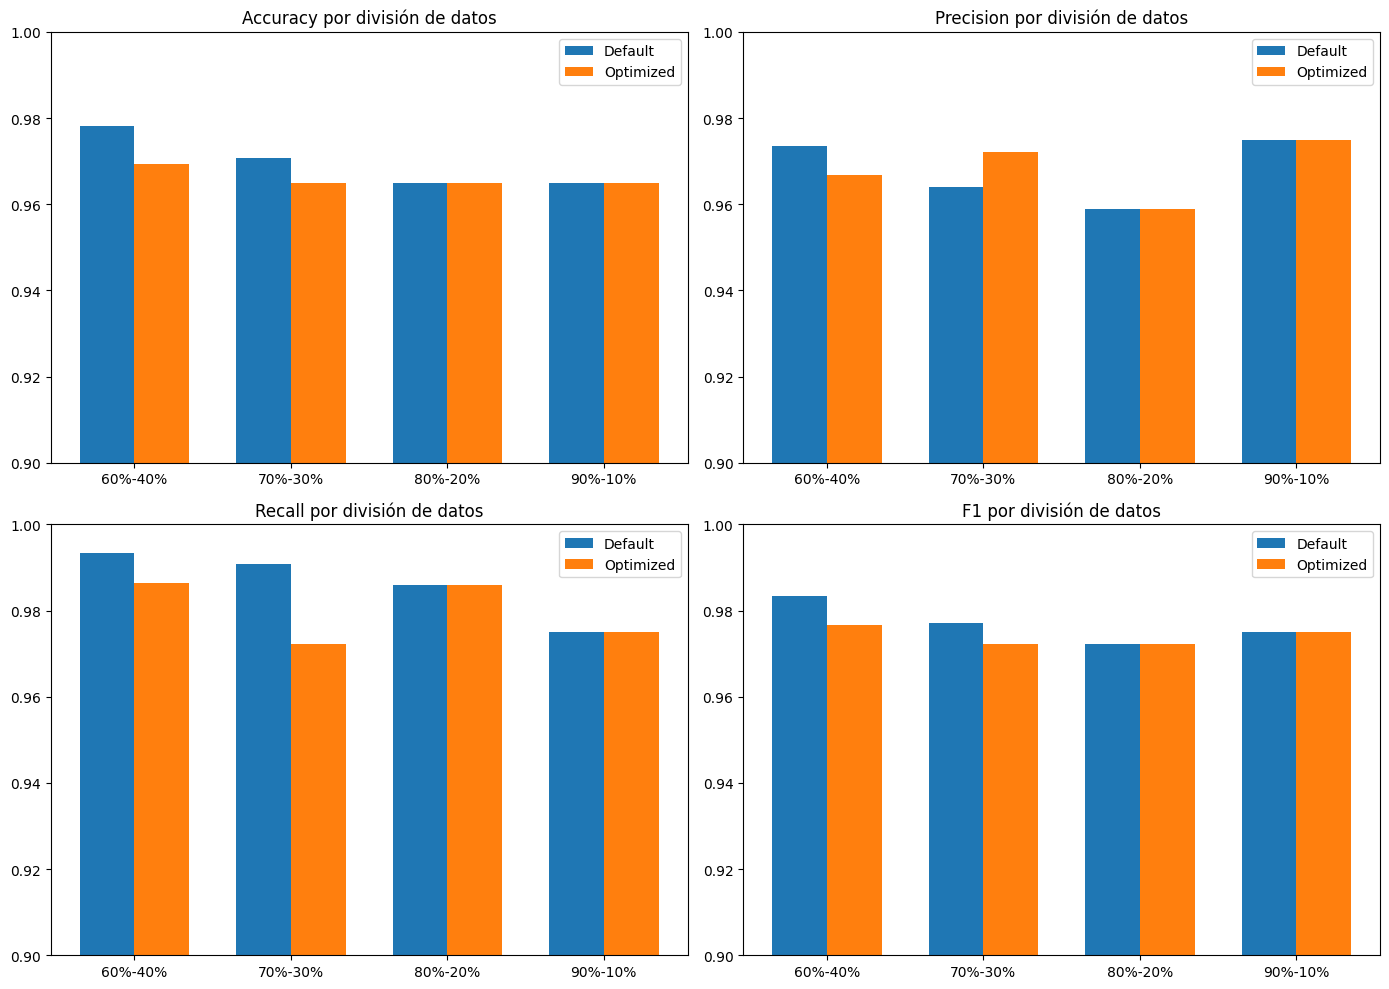

In [36]:
# Visualizar resultados
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    default_values = [result[f'Default {metric}'] for result in results]
    optimized_values = [result[f'Optimized {metric}'] for result in results]

    x = np.arange(len(splits))
    width = 0.35

    axes[i].bar(x - width/2, default_values, width, label='Default')
    axes[i].bar(x + width/2, optimized_values, width, label='Optimized')

    axes[i].set_title(f'{metric} por división de datos')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([f'{int(s*100)}%-{int(t*100)}%' for s, t in zip(splits, test_sizes)])
    axes[i].legend()
    axes[i].set_ylim(0.9, 1.0)  # Ajustar para ver mejor las diferencias

plt.tight_layout()
plt.savefig('random_forest_comparison.png', dpi=300)
plt.show()

In [37]:
# Mejora en rendimiento
improvement = pd.DataFrame({
    'Train-Test Split': [result['Train-Test Split'] for result in results],
    'Accuracy Improvement': [result['Optimized Accuracy'] - result['Default Accuracy'] for result in results],
    'Precision Improvement': [result['Optimized Precision'] - result['Default Precision'] for result in results],
    'Recall Improvement': [result['Optimized Recall'] - result['Default Recall'] for result in results],
    'F1 Improvement': [result['Optimized F1'] - result['Default F1'] for result in results]
})

print("\nMejora porcentual con optimización bayesiana:")
print(improvement.set_index('Train-Test Split') * 100)


Mejora porcentual con optimización bayesiana:
                  Accuracy Improvement  Precision Improvement  \
Train-Test Split                                                
60%-40%                      -0.877193              -0.662252   
70%-30%                      -0.584795               0.825826   
80%-20%                       0.000000               0.000000   
90%-10%                       0.000000               0.000000   

                  Recall Improvement  F1 Improvement  
Train-Test Split                                      
60%-40%                    -0.675676       -0.668896  
70%-30%                    -1.851852       -0.494673  
80%-20%                     0.000000        0.000000  
90%-10%                     0.000000        0.000000  


### Random Forest Sin y Con Random Search ⏰

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
# Cargar dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [10]:
# Definir divisiones de datos
splits = [0.6, 0.7, 0.8, 0.9]
test_sizes = [0.4, 0.3, 0.2, 0.1]

In [40]:
# Resultados
results = []

# Para cada división
for train_size, test_size in zip(splits, test_sizes):
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    ##Oversampling - resample-smote (y_train)

    # 1. Random Forest sin optimización de hiperparámetros
    rf_default = RandomForestClassifier(random_state=42)
    rf_default.fit(X_train, y_train)
    y_pred_default = rf_default.predict(X_test)

    # Métricas
    accuracy_default = accuracy_score(y_test, y_pred_default)
    precision_default = precision_score(y_test, y_pred_default)
    recall_default = recall_score(y_test, y_pred_default)
    f1_default = f1_score(y_test, y_pred_default)

    # 2. Random Forest con optimización de hiperparámetros (usando RandomizedSearchCV como alternativa a Bayesian)
    param_space = {
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    }

    # Búsqueda aleatoria (similar a la optimización bayesiana)
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_space,
        n_iter=10,  # Número de combinaciones a probar
        cv=5,
        n_jobs=-1,
        random_state=42,
        scoring='f1'
    )

    random_search.fit(X_train, y_train)

    # Mejor modelo
    rf_optimized = random_search.best_estimator_
    y_pred_optimized = rf_optimized.predict(X_test)

    # Métricas
    accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
    precision_optimized = precision_score(y_test, y_pred_optimized)
    recall_optimized = recall_score(y_test, y_pred_optimized)
    f1_optimized = f1_score(y_test, y_pred_optimized)

    # Guardar resultados
    results.append({
        'Train-Test Split': f'{int(train_size*100)}%-{int(test_size*100)}%',
        'Default Accuracy': accuracy_default,
        'Default Precision': precision_default,
        'Default Recall': recall_default,
        'Default F1': f1_default,
        'Optimized Accuracy': accuracy_optimized,
        'Optimized Precision': precision_optimized,
        'Optimized Recall': recall_optimized,
        'Optimized F1': f1_optimized,
        'Best Parameters': random_search.best_params_
    })

In [41]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results)

# Mostrar resultados
print("Resultados de Random Forest con diferentes divisiones de datos:")
print(results_df[['Train-Test Split', 'Default Accuracy', 'Optimized Accuracy']])
print("\nMejores hiperparámetros encontrados:")
for i, split in enumerate(['60%-40%', '70%-30%', '80%-20%','90%-10%']):
    print(f"\nPara división {split}:")
    for param, value in results[i]['Best Parameters'].items():
        print(f"  {param}: {value}")

Resultados de Random Forest con diferentes divisiones de datos:
  Train-Test Split  Default Accuracy  Optimized Accuracy
0          60%-40%          0.978070            0.969298
1          70%-30%          0.970760            0.976608
2          80%-20%          0.964912            0.964912
3          90%-10%          0.964912            0.964912

Mejores hiperparámetros encontrados:

Para división 60%-40%:
  n_estimators: 10
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: 0.3
  max_depth: None
  criterion: gini
  bootstrap: False

Para división 70%-30%:
  n_estimators: 10
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: 0.3
  max_depth: None
  criterion: gini
  bootstrap: False

Para división 80%-20%:
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: None
  criterion: entropy
  bootstrap: False

Para división 90%-10%:
  n_estimators: 10
  min_samples_split: 10
  min_samples_leaf: 1
  max_features: log2
  max_

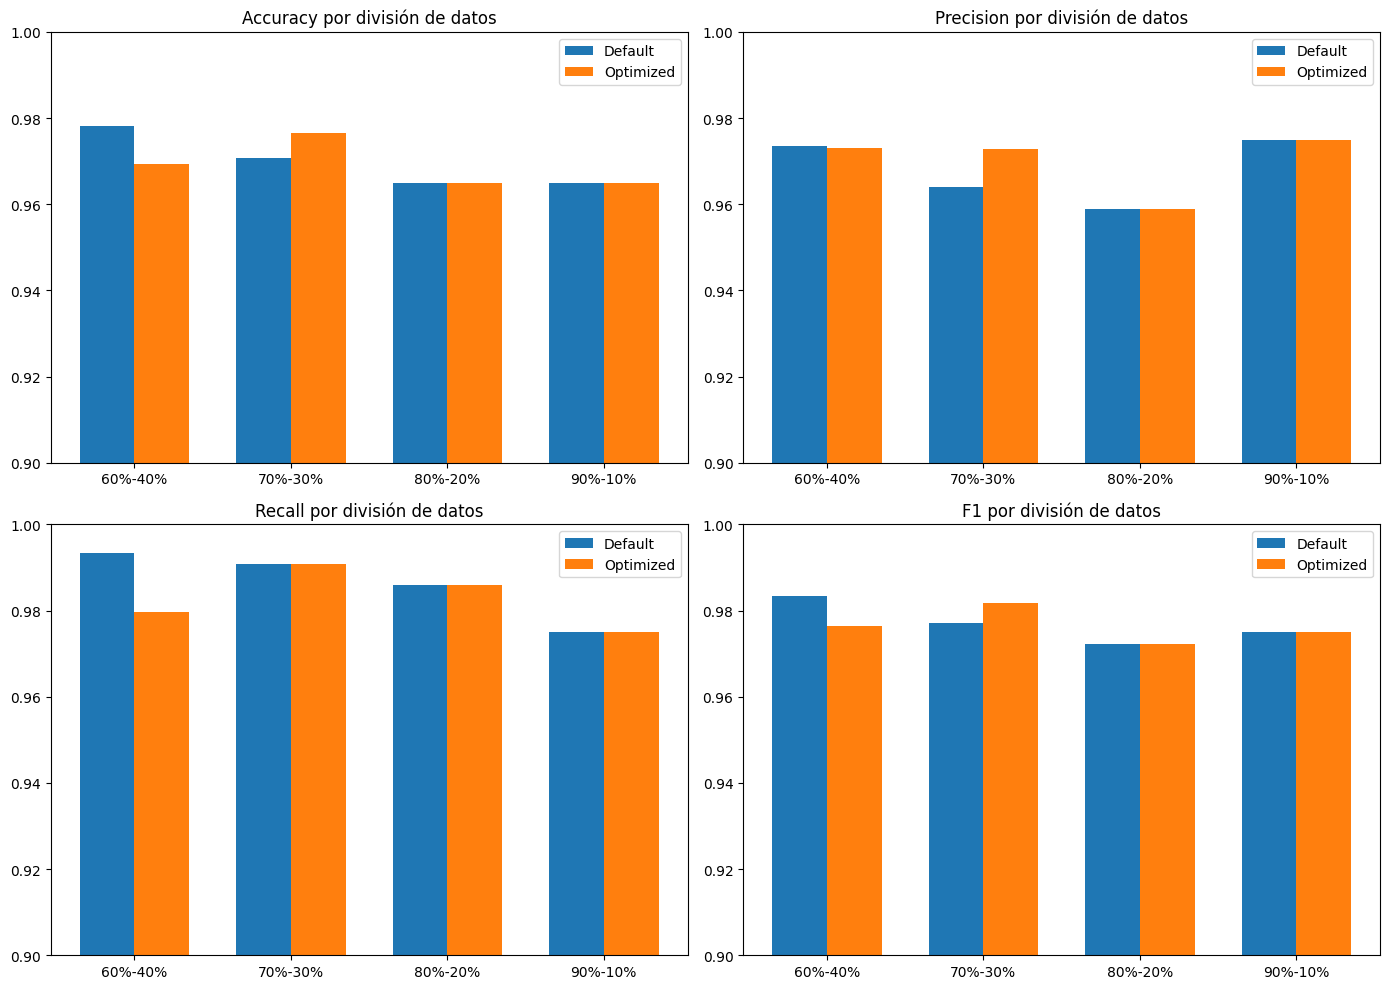

In [42]:
# Visualizar resultados
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    default_values = [result[f'Default {metric}'] for result in results]
    optimized_values = [result[f'Optimized {metric}'] for result in results]

    x = np.arange(len(splits))
    width = 0.35

    axes[i].bar(x - width/2, default_values, width, label='Default')
    axes[i].bar(x + width/2, optimized_values, width, label='Optimized')

    axes[i].set_title(f'{metric} por división de datos')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([f'{int(s*100)}%-{int(t*100)}%' for s, t in zip(splits, test_sizes)])
    axes[i].legend()
    axes[i].set_ylim(0.9, 1.0)  # Ajustar para ver mejor las diferencias

plt.tight_layout()
plt.savefig('random_forest_comparison.png')
plt.show()

In [43]:
# Mejora en rendimiento
improvement = pd.DataFrame({
    'Train-Test Split': [result['Train-Test Split'] for result in results],
    'Accuracy Improvement': [result['Optimized Accuracy'] - result['Default Accuracy'] for result in results],
    'Precision Improvement': [result['Optimized Precision'] - result['Default Precision'] for result in results],
    'Recall Improvement': [result['Optimized Recall'] - result['Default Recall'] for result in results],
    'F1 Improvement': [result['Optimized F1'] - result['Default F1'] for result in results]
})

print("\nMejora porcentual con optimización de hiperparámetros:")
print(improvement.set_index('Train-Test Split') * 100)


Mejora porcentual con optimización de hiperparámetros:
                  Accuracy Improvement  Precision Improvement  \
Train-Test Split                                                
60%-40%                      -0.877193              -0.035557   
70%-30%                       0.584795               0.876331   
80%-20%                       0.000000               0.000000   
90%-10%                       0.000000               0.000000   

                  Recall Improvement  F1 Improvement  
Train-Test Split                                      
60%-40%                    -1.351351       -0.684662  
70%-30%                     0.000000        0.448243  
80%-20%                     0.000000        0.000000  
90%-10%                     0.000000        0.000000  


### Random Forest y XgBoost Comparativa ⏰

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            classification_report, roc_curve, auc, RocCurveDisplay)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Cargar dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Definir divisiones de datos (ordenadas)
splits = [0.6, 0.7, 0.8, 0.9]
test_sizes = [0.4, 0.3, 0.2, 0.1]
split_names = ['60%-40%', '70%-30%', '80%-20%','90%-10%']



Procesando división 60%-40%

Reporte de clasificación para Random Forest (60%-40%):
              precision    recall  f1-score   support

     Maligno       0.99      0.95      0.97        80
     Benigno       0.97      0.99      0.98       148

    accuracy                           0.98       228
   macro avg       0.98      0.97      0.98       228
weighted avg       0.98      0.98      0.98       228


Reporte de clasificación para XGBoost (60%-40%):
              precision    recall  f1-score   support

     Maligno       0.95      0.93      0.94        80
     Benigno       0.96      0.97      0.97       148

    accuracy                           0.96       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.96      0.96      0.96       228


Procesando división 70%-30%

Reporte de clasificación para Random Forest (70%-30%):
              precision    recall  f1-score   support

     Maligno       0.98      0.94      0.96        63
     Benigno     

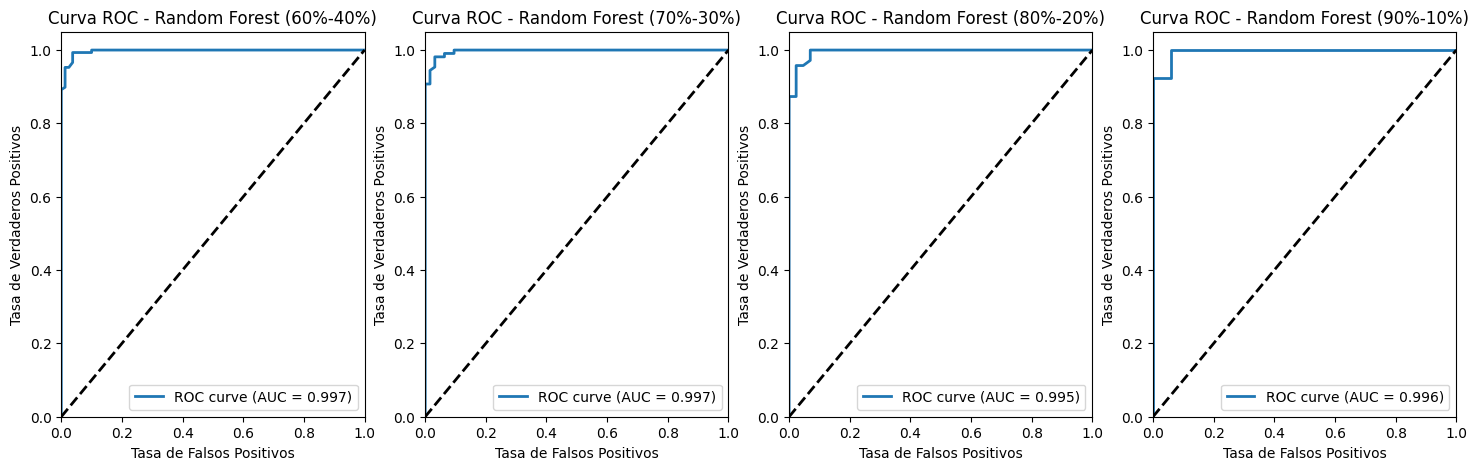

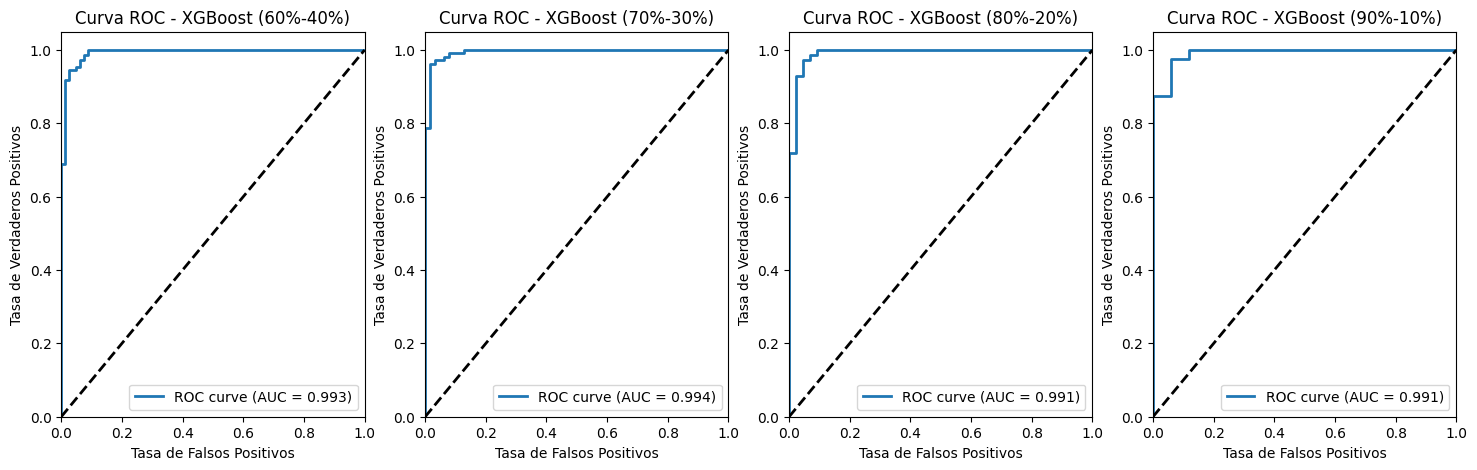

In [46]:
# Resultados
rf_results = []
xgb_results = []

# Configuración de figuras para curvas ROC
fig_rf, axes_rf = plt.subplots(1, 4, figsize=(18, 5))
fig_xgb, axes_xgb = plt.subplots(1, 4, figsize=(18, 5))
# Para cada división
for i, (train_size, test_size, split_name) in enumerate(zip(splits, test_sizes, split_names)):
    print(f"\n{'='*50}")
    print(f"Procesando división {split_name}")
    print(f"{'='*50}")

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # 1. Random Forest sin optimización
    rf_default = RandomForestClassifier(random_state=42)
    rf_default.fit(X_train, y_train)
    y_pred_rf = rf_default.predict(X_test)
    y_prob_rf = rf_default.predict_proba(X_test)[:, 1]

    # Métricas RF
    accuracy_rf = accuracy_score(y_test, y_pred_rf)

    # 2. XGBoost sin optimización
    xgb_default = xgb.XGBClassifier(random_state=42)
    xgb_default.fit(X_train, y_train)
    y_pred_xgb = xgb_default.predict(X_test)
    y_prob_xgb = xgb_default.predict_proba(X_test)[:, 1]

    # Métricas XGBoost
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

    # Guardar resultados
    rf_results.append({
        'Split': split_name,
        'Accuracy': accuracy_rf,
        'Predictions': y_pred_rf,
        'Probabilities': y_prob_rf,
        'y_test': y_test
    })

    xgb_results.append({
        'Split': split_name,
        'Accuracy': accuracy_xgb,
        'Predictions': y_pred_xgb,
        'Probabilities': y_prob_xgb,
        'y_test': y_test
    })

    # Reportes de clasificación
    print(f"\nReporte de clasificación para Random Forest ({split_name}):")
    print(classification_report(y_test, y_pred_rf, target_names=['Maligno', 'Benigno']))

    print(f"\nReporte de clasificación para XGBoost ({split_name}):")
    print(classification_report(y_test, y_pred_xgb, target_names=['Maligno', 'Benigno']))

    # Curvas ROC
    # Para Random Forest
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    # Para XGBoost
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

    # Graficar curvas ROC
    # Random Forest
    axes_rf[i].plot(fpr_rf, tpr_rf, lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
    axes_rf[i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes_rf[i].set_xlim([0.0, 1.0])
    axes_rf[i].set_ylim([0.0, 1.05])
    axes_rf[i].set_xlabel('Tasa de Falsos Positivos')
    axes_rf[i].set_ylabel('Tasa de Verdaderos Positivos')
    axes_rf[i].set_title(f'Curva ROC - Random Forest ({split_name})')
    axes_rf[i].legend(loc="lower right")

    # XGBoost
    axes_xgb[i].plot(fpr_xgb, tpr_xgb, lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.3f})')
    axes_xgb[i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes_xgb[i].set_xlim([0.0, 1.0])
    axes_xgb[i].set_ylim([0.0, 1.05])
    axes_xgb[i].set_xlabel('Tasa de Falsos Positivos')
    axes_xgb[i].set_ylabel('Tasa de Verdaderos Positivos')
    axes_xgb[i].set_title(f'Curva ROC - XGBoost ({split_name})')
    axes_xgb[i].legend(loc="lower right")

In [47]:
# Ajustar y guardar figuras
fig_rf.tight_layout()
fig_rf.savefig('random_forest_roc_curves.png')

fig_xgb.tight_layout()
fig_xgb.savefig('xgboost_roc_curves.png')

In [48]:
# Comparación de modelos
comparison_data = []
for i, split_name in enumerate(split_names):
    comparison_data.append({
        'Split': split_name,
        'RF Accuracy': rf_results[i]['Accuracy'],
        'XGB Accuracy': xgb_results[i]['Accuracy'],
        'Difference': xgb_results[i]['Accuracy'] - rf_results[i]['Accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n\nComparación de precisión entre Random Forest y XGBoost:")
print(comparison_df)



Comparación de precisión entre Random Forest y XGBoost:
     Split  RF Accuracy  XGB Accuracy  Difference
0  60%-40%     0.978070      0.956140   -0.021930
1  70%-30%     0.970760      0.970760    0.000000
2  80%-20%     0.964912      0.956140   -0.008772
3  90%-10%     0.964912      0.964912    0.000000


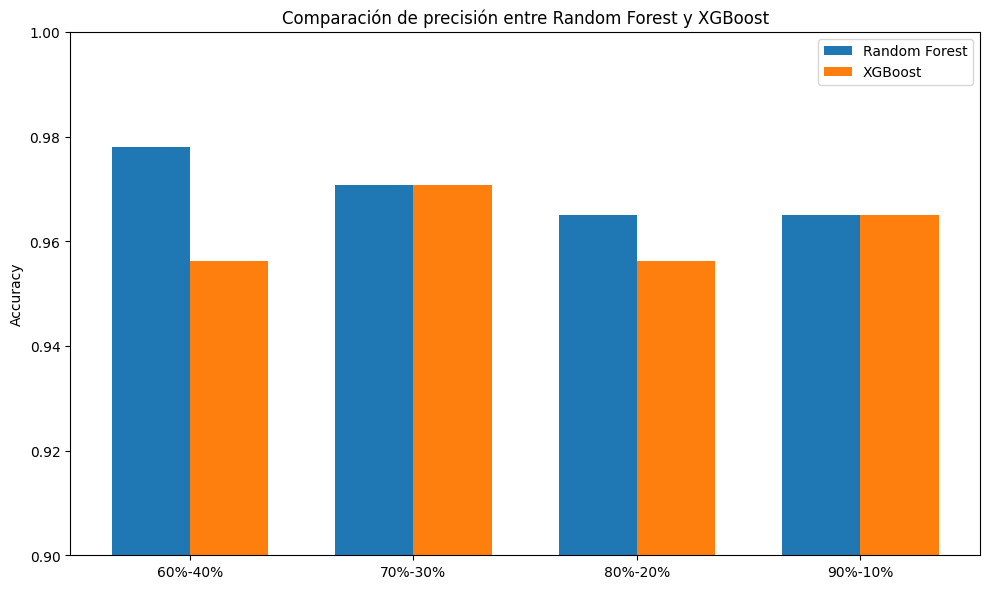

In [49]:
# Gráfico de comparación
plt.figure(figsize=(10, 6))
x = np.arange(len(split_names))
width = 0.35

plt.bar(x - width/2, comparison_df['RF Accuracy'], width, label='Random Forest')
plt.bar(x + width/2, comparison_df['XGB Accuracy'], width, label='XGBoost')

plt.title('Comparación de precisión entre Random Forest y XGBoost')
plt.xticks(x, split_names)
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.legend()

plt.tight_layout()
plt.savefig('rf_vs_xgboost_comparison.png')

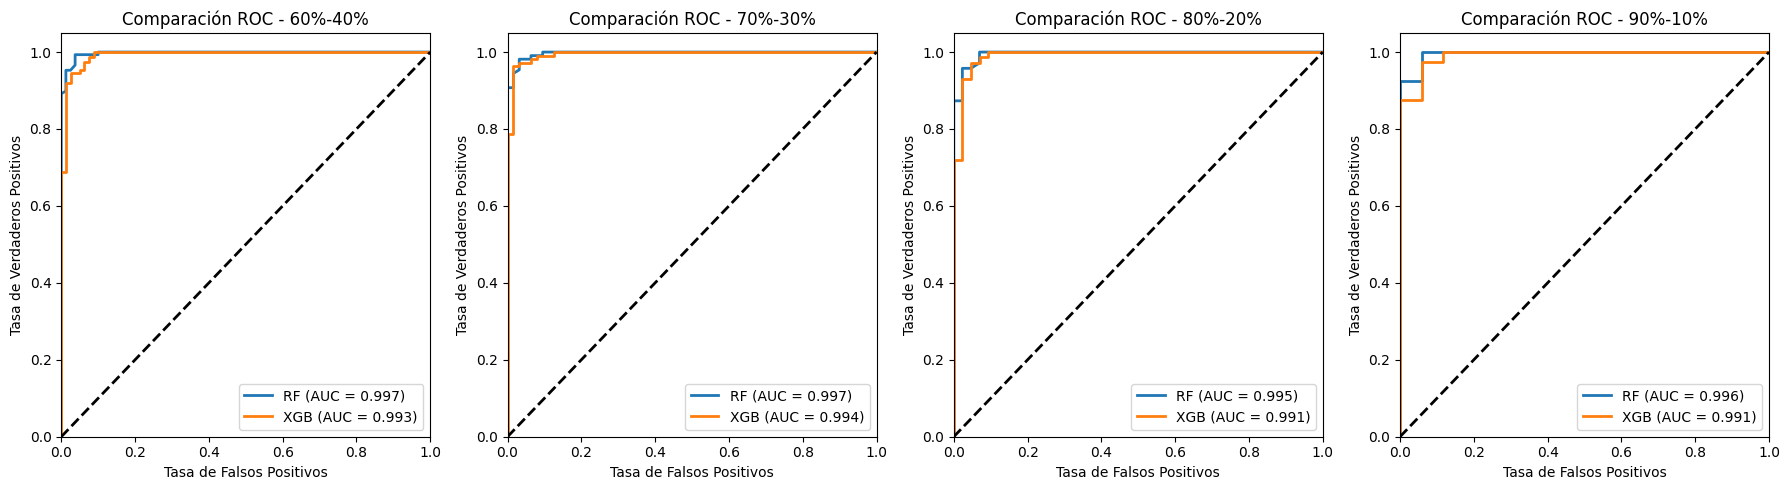

In [51]:
# Crear una figura para comparar las curvas ROC de ambos modelos en cada división
fig_compare, axes_compare = plt.subplots(1, 4, figsize=(18, 5))

for i, split_name in enumerate(split_names):
    # Obtener datos ROC
    fpr_rf, tpr_rf, _ = roc_curve(rf_results[i]['y_test'], rf_results[i]['Probabilities'])
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    fpr_xgb, tpr_xgb, _ = roc_curve(xgb_results[i]['y_test'], xgb_results[i]['Probabilities'])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

    # Graficar ambas curvas en el mismo gráfico
    axes_compare[i].plot(fpr_rf, tpr_rf, lw=2, label=f'RF (AUC = {roc_auc_rf:.3f})')
    axes_compare[i].plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGB (AUC = {roc_auc_xgb:.3f})')
    axes_compare[i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes_compare[i].set_xlim([0.0, 1.0])
    axes_compare[i].set_ylim([0.0, 1.05])
    axes_compare[i].set_xlabel('Tasa de Falsos Positivos')
    axes_compare[i].set_ylabel('Tasa de Verdaderos Positivos')
    axes_compare[i].set_title(f'Comparación ROC - {split_name}')
    axes_compare[i].legend(loc="lower right")

fig_compare.tight_layout()
fig_compare.savefig('rf_vs_xgboost_roc_comparison.png')

# Mostrar todas las figuras
plt.show()

In [52]:
# Resumen final
print("\n\nRESUMEN FINAL DE RESULTADOS:")
print("="*50)
print("Métricas de Random Forest por división:")
for result in rf_results:
    print(f"División {result['Split']}: Accuracy = {result['Accuracy']:.4f}")

print("\nMétricas de XGBoost por división:")
for result in xgb_results:
    print(f"División {result['Split']}: Accuracy = {result['Accuracy']:.4f}")

print("\nDiferencia (XGBoost - Random Forest):")
for comp in comparison_data:
    print(f"División {comp['Split']}: {comp['Difference']:.4f}")



RESUMEN FINAL DE RESULTADOS:
Métricas de Random Forest por división:
División 60%-40%: Accuracy = 0.9781
División 70%-30%: Accuracy = 0.9708
División 80%-20%: Accuracy = 0.9649
División 90%-10%: Accuracy = 0.9649

Métricas de XGBoost por división:
División 60%-40%: Accuracy = 0.9561
División 70%-30%: Accuracy = 0.9708
División 80%-20%: Accuracy = 0.9561
División 90%-10%: Accuracy = 0.9649

Diferencia (XGBoost - Random Forest):
División 60%-40%: -0.0219
División 70%-30%: 0.0000
División 80%-20%: -0.0088
División 90%-10%: 0.0000
